# Генерация изображений животных

Импортируем библиотеки

In [15]:
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import torch
from torch.optim import Adam
import torch.nn as nn
from PIL import Image
import os
import cv2
import matplotlib.pyplot as plt

Для работы можно использовать любой датасет. Petfaces работает быстрее, поэтому возьмём его. Генерировать будет на GPU. Также зададим директорию, в которую будем записывать изображения по ходу генерации

In [16]:
dataset_path = r"C:\gm\petfaces"

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def create_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

save_dir = "./res"
create_dir(save_dir)

Определим класс для создания датасета. Выполним преобразованию и создадим dataloader. Для генерации будем использовать ResNet

In [18]:
class PetFacesDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        for subdir, dirs, files in os.walk(root_dir):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_files.append(os.path.join(subdir, file))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]

        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image  
            
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Lambda(lambda x: x.convert('RGB')),
    transforms.ToTensor(),
])

dataset = PetFacesDataset(dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

resnet = models.resnet18(pretrained=True).to(device)

for param in resnet.parameters():
    param.requires_grad = False

num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, 512).to(device)

Реализуем GAN. Для этого определим классы для генератора и дискриминатора

In [19]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(100, 512 * 4 * 4),  # 100 - размер входного шума, 512*4*4 - желаемый размер выхода
            nn.ReLU()
        )
        self.deconv_layers = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # Размер входа соответствует выходу fc
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        # Преобразование входного шума в выходной вектор полносвязного слоя
        x = self.fc(z)
        x = x.view(-1, 512, 4, 4)  # Изменение формы входного вектора для деконволюционных слоев
        # Генерация изображения
        image = self.deconv_layers(x)
        return image

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3 * 64 * 64, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        return self.model(img.view(img.size(0), -1))

Создадим генератор и дискриминатор. Определим количество эпох, коэффициент сглаживания и число N, которое пригодится нам позже. Я буду использовать не очень много эпох, чтобы программа выполнилась быстро 

In [20]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

g_optimizer = Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

smooth = 0.1
epochs = 1000
N = 50

Определим функцию для визуализации изображения (в добавок к сохранению на диске)

In [21]:
def visualize(generator):
    generator.eval()
    z = torch.randn(1, 100, device=device)
    with torch.no_grad():
        generated_image = generator(z).detach().cpu()
        
    generated_image = generated_image.squeeze(0).permute(1, 2, 0)
    
    generated_image = (generated_image + 1) / 2
    generated_image = generated_image.clamp(0, 1)
    
    plt.imshow(generated_image)
    plt.axis('off')
    plt.show()

Начнём процесс генерации. Каждые N эпох изображение будет визуализировано. Размер изображений - 64x64, однако его можно увеличить при желании, но это займёт больше времени, однако качество будет существенно выше. 

**Также важно отметить, что визуализация с помощью matplotlib не передаёт точность оригинальных картинок. Они сохранятся в директории ./res**

Epoch: 0, Batch: 0, D Loss: 1.3912490606307983, G Loss: 1.012392520904541


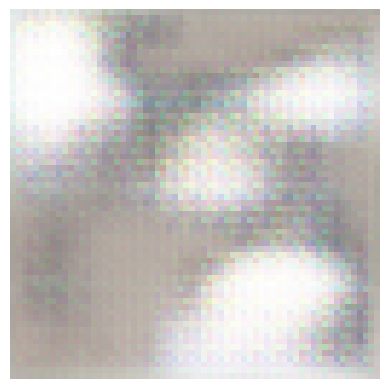

Epoch: 50, Batch: 0, D Loss: 1.338973045349121, G Loss: 0.8114073276519775


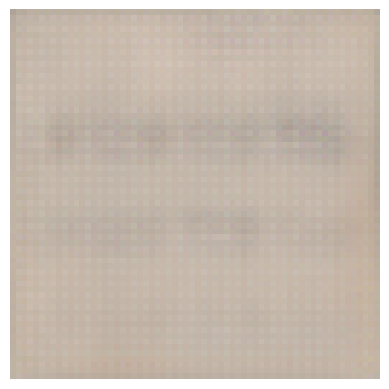

Epoch: 100, Batch: 0, D Loss: 1.351482629776001, G Loss: 0.7699207067489624


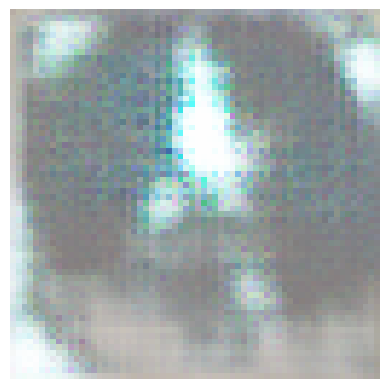

Epoch: 150, Batch: 0, D Loss: 1.3516993522644043, G Loss: 0.7324811220169067


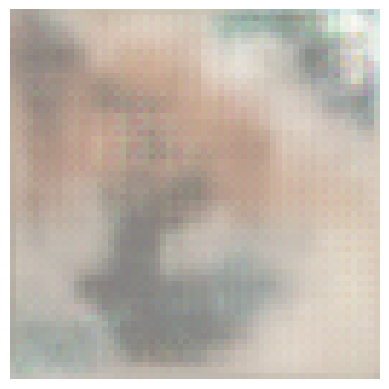

Epoch: 200, Batch: 0, D Loss: 1.3751524686813354, G Loss: 0.7968668937683105


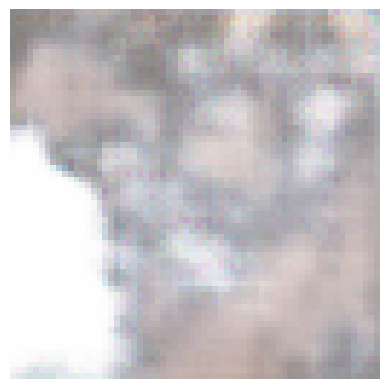

Epoch: 250, Batch: 0, D Loss: 1.2900601625442505, G Loss: 0.8367292284965515


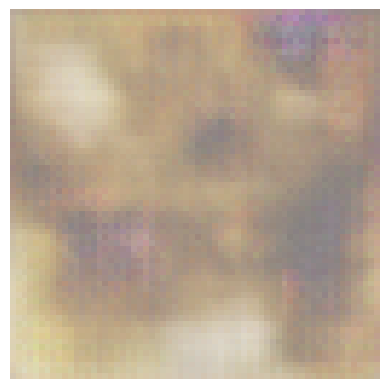

Epoch: 300, Batch: 0, D Loss: 1.3159153461456299, G Loss: 1.0185508728027344


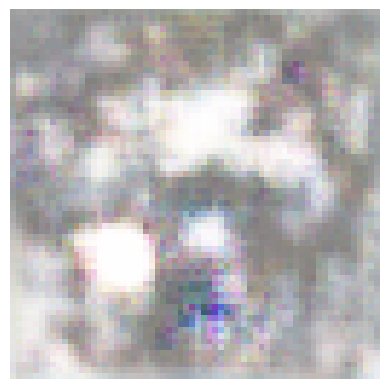

Epoch: 350, Batch: 0, D Loss: 1.327582597732544, G Loss: 0.7587213516235352


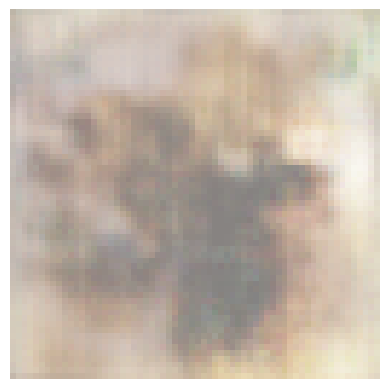

Epoch: 400, Batch: 0, D Loss: 1.3127872943878174, G Loss: 0.8424279689788818


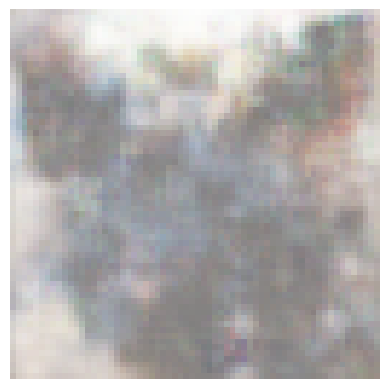

Epoch: 450, Batch: 0, D Loss: 1.3380494117736816, G Loss: 1.0366628170013428


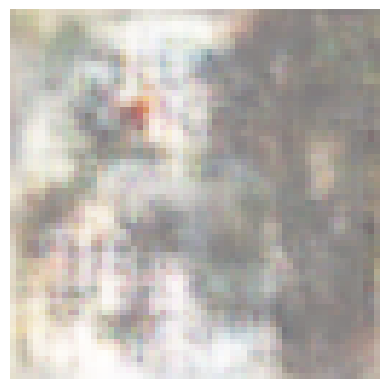

Epoch: 500, Batch: 0, D Loss: 1.2812728881835938, G Loss: 0.9687275290489197


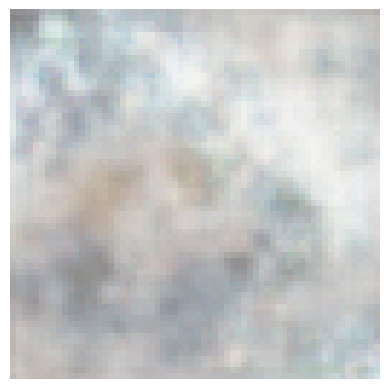

Epoch: 550, Batch: 0, D Loss: 1.3254051208496094, G Loss: 0.8764844536781311


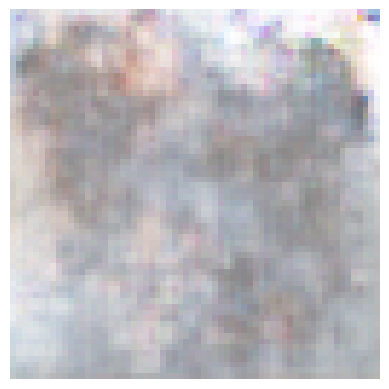

Epoch: 600, Batch: 0, D Loss: 1.1977472305297852, G Loss: 0.9900784492492676


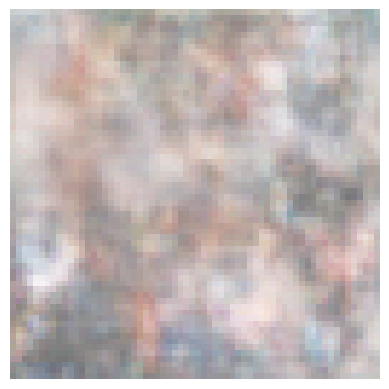

Epoch: 650, Batch: 0, D Loss: 1.2801439762115479, G Loss: 1.0562808513641357


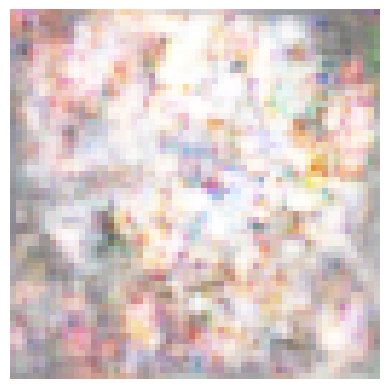

Epoch: 700, Batch: 0, D Loss: 1.0291266441345215, G Loss: 1.117114543914795


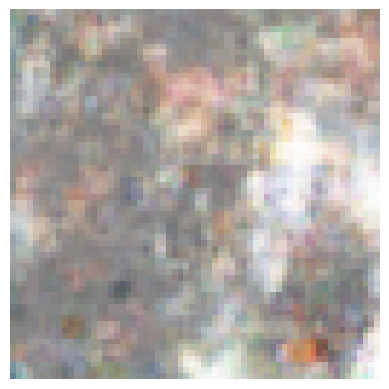

Epoch: 750, Batch: 0, D Loss: 1.1077488660812378, G Loss: 1.2876322269439697


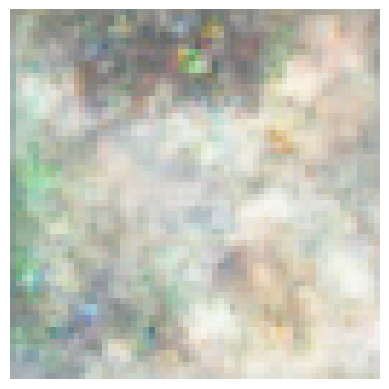

Epoch: 800, Batch: 0, D Loss: 1.0987780094146729, G Loss: 1.228532314300537


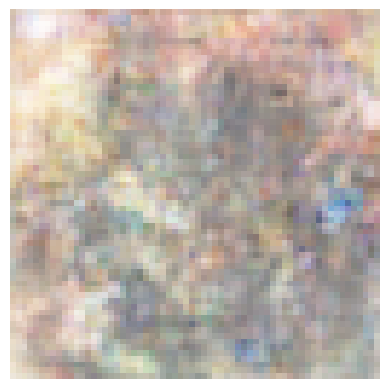

Epoch: 850, Batch: 0, D Loss: 1.0013206005096436, G Loss: 1.4013341665267944


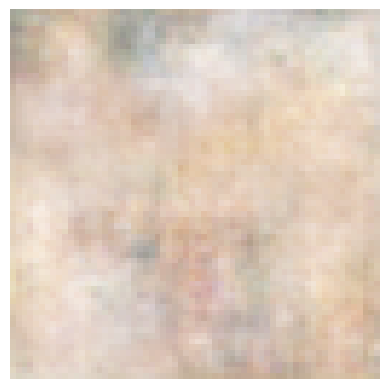

Epoch: 900, Batch: 0, D Loss: 1.0322606563568115, G Loss: 1.6498051881790161


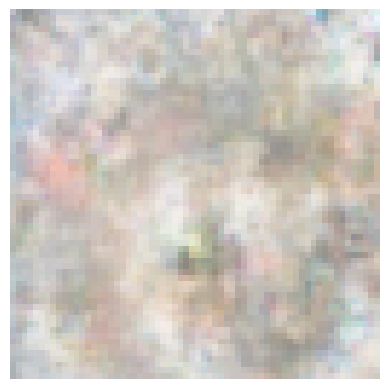

Epoch: 950, Batch: 0, D Loss: 1.1858439445495605, G Loss: 1.3804374933242798


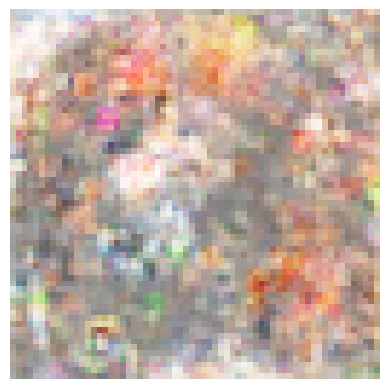

In [22]:
for epoch in range(epochs):
    for i, images in enumerate(dataloader):
        # Перенос изображений на GPU
        images = images.to(device)
        
        # Размер батча для текущей итерации
        batch_size = images.size(0)
        
        # Реальные метки с label smoothing
        real_labels = (1 - smooth) * torch.ones(batch_size, 1).to(device)
        fake_labels = smooth * torch.zeros(batch_size, 1).to(device)

        # Тренировка дискриминатора
        d_optimizer.zero_grad()

        # Реальные изображения
        real_validity = discriminator(images)
        d_real_loss = nn.functional.binary_cross_entropy(real_validity, real_labels)

        # Генерация поддельных изображений
        z = torch.randn(batch_size, 100, device=device)
        fake_images = generator(z)
        fake_validity = discriminator(fake_images.detach())
        d_fake_loss = nn.functional.binary_cross_entropy(fake_validity, fake_labels)

        d_loss = d_real_loss + d_fake_loss
        
        # Обратное распространение для дискриминатора
        d_loss.backward()
        # Применение Gradient Clipping
        nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=1.0)
        d_optimizer.step()

        # Тренировка генератора
        g_optimizer.zero_grad()
        
        # Потери генератора
        fake_validity = discriminator(fake_images)
        g_loss = nn.functional.binary_cross_entropy(fake_validity, real_labels)
        
        # Обратное распространение для генератора
        g_loss.backward()
        nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)
        g_optimizer.step()

        if epoch % N == 0 and i == 0:
            print(f"Epoch: {epoch}, Batch: {i}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

    if (epoch + 1) % N == 0:
        with torch.no_grad():
            generator.eval()
            z = torch.randn(1, 100, device=device)
            generated_images = generator(z)
            save_image(generated_images, f"{save_dir}/{epoch+1}.png", normalize=True)
            
            visualize(generator)